In [1]:
#libraries
import os 
import pandas as pd
import numpy as np 
import h5py
import math
import collections
import filecmp
from lxml import etree as ET
#import xml.etree.ElementTree as ET
import datetime
from collections import OrderedDict
#import pandasql as ps
from operator import itemgetter
import csv
from collections import Counter
#from google.colab import drive

import geopandas as gpd
#import pandasql as ps
import matplotlib.pyplot as plt
import shapefile as shp
import seaborn as sns
import random
import time
from sklearn.model_selection import train_test_split
#import pysal as ps
import scipy
import fiona

from scipy.stats import kstest
from scipy.stats import mannwhitneyu

from dill.source import getsource

In [2]:
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018')

In [3]:
#import torch.nn as nn

In [4]:
#os.chdir('G:/My Drive/2021/Bias/recsys_test/ml-20m/psrc_test_01')
#train = pd.read_csv('train.csv').to_numpy()

In [58]:
#torch.FloatTensor(train)

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

## PSRC simulation data extract

In [9]:
#Mount
#create drive content
#drive.mount('/content/drive', force_remount= True)
os.chdir('G:/My Drive/2021/Bias/PSRC_od_simulation_2018')
#os.listdir()

# Create functions to open the tables in daysim_outputs.h5
def h5_to_data_frame(h5file, table_name):
    table = h5file[table_name]
    col_dict = {}
    #cols = ['hhno', 'hhtaz']
    for col in table.keys():
        if col == 'sov_ff_time':
            pass
        else:
            my_array = np.asarray(table[col]).astype('int')
        col_dict[col] = my_array.astype('int')
    return(pd.DataFrame(col_dict))

# Create functions to check the data
def print_dt_info(dt, dtname):
    print(dtname)
    print('shape', dt.shape)
    print('colnames', dt.columns)
    

#taz related
def check_odtaz(input_od, selected_taz):
    o, d = input_od
    if o not in selected_taz and d not in selected_taz:
        print('warning! od both not in the selected taz')
        print(input_od)


def conduct_sampling(selected_dt, democol, paramarr):
    selected_dt = selected_dt.sort_values(by=[democol])
    demo_num = np.unique(selected_dt[democol])
    selected_ids = []
    
    for demo_i in demo_num:
        demo_ids = list(selected_dt['person_id'][selected_dt[democol]==demo_i].values)
        demo_pop = len(demo_ids)
        demo_sample_pop = int(round(demo_pop * paramarr[demo_i-1], 0))
        #print(demo_sample_pop), no replacement
        selected_ids.extend(random.sample(demo_ids, demo_sample_pop))
    return(selected_ids)

def get_sample_dttrips(selected_ids, trip_dt, has_stays = False):
    sample_dt = trip_dt[trip_dt['person_id'].isin(selected_ids)]
    #check stays for sampling based on all the data
    if has_stays == True:
        stays_id = []
        for i in selected_ids:
            if i not in np.unique(sample_dt['person_id']):
                stays_id.append(i)
        return(sample_dt, stays_id)
    else:
        return(sample_dt)

#get stayed taz
def get_stayed_taz(stay_ids, home_taz):
    person_id_taz = {}
    for i in stay_ids:
        stays_ = int(i.split('_')[0])
        person_id_taz[i] = home_taz[stays_]
        if stays_ not in home_taz:
            print(stays_)
    return(person_id_taz)

#decode the data
#for age, pagey
#<18, 18-29, 30-49, 50-64, >65
def decode_age(age_var):
    if age_var<18 and age_var>=0:
        return(0)
    elif age_var>=18 and age_var<=29:
        return(1)
    elif age_var>=30 and age_var<=49:
        return(2)
    elif age_var>=50 and age_var<=64:
        return(3)
    elif age_var>=65:
        return(4)
    else:
        return('nan')
    
#for household income, hhincome
#Poor or near-poor 32,048 or less
#Lower-middle class 32,048 - 53,413
#Middle class 53,413 - 106,827
#Upper-middle class 106,827 - 373,894
#Rich 373,894 and up
def decode_income(income_var):
    if income_var != -1:
        if income_var<=0:
            return(0)
        elif income_var>0 and income_var<32048:
            return(1)
        elif income_var>=32048 and income_var<53413:
            return(2)
        elif income_var>=53413 and income_var<106827:
            return(3)
        elif income_var>=106827 and income_var<373894:
            return(4)
        else:
            return(5)    
    else:
        return(-1)
    
def decode_income_3level(income_var):
    if income_var != -1:
        if income_var<=0:
            return(1)
        elif income_var>0 and income_var<32048:
            return(1)
        elif income_var>=32048 and income_var<53413:
            return(1)
        elif income_var>=53413 and income_var<106827:
            return(2)
        elif income_var>=106827 and income_var<373894:
            return(2)
        else:
            return(3)    
    else:
        return(-1)
    
def decode_income_pew(income_var):
    if income_var != -1:
        if income_var<=0:
            return(1)
        elif income_var>0 and income_var<30000:
            return(1)
        elif income_var>=30000 and income_var<=49999:
            return(2)
        elif income_var>=50000 and income_var<=74999:
            return(3)
        elif income_var>=75000:
            return(4)
    else:
        return(-1)

In [6]:
# Read the daysim_outputs file
#hdf_file = h5py.File(r'/content/drive/My Drive/Colab Notebooks/Project/daysim_outputs.h5', "r")
hdf_file = h5py.File(r'daysim_outputs.h5', "r")

# output_dir = r'\\modelstation3\c$\\Workspace\sc_new_emp_SCEN3_2018'
print(hdf_file.keys())


# Get the tables: trips, person, household, tours
#get trip data
trips = h5_to_data_frame(hdf_file, 'Trip')
# get trips columns to use later
trips_columns = trips.columns
trips['person_id'] = trips['hhno'].astype(str) + '_' + trips['pno'].astype(str)

#get information we need
path= 'G:/My Drive/2021/Bias/SUMO_simulation/MatSumo-main/SUMO/SUMO_network/'
datafile = 'Taz_with_pseudo_link.add.xml'
tree = ET.parse(path+datafile)
root = tree.getroot()
selected_taz = []
for taz in root.findall('taz'):
    tazid = taz.get('id')
    #filter out pseudo taz
    if len(tazid) <=3:
        selected_taz.append(int(tazid))
        
#selected taz 
print(trips.shape)
trip_revised = trips[(trips['otaz'].isin(selected_taz))|(trips['dtaz'].isin(selected_taz))]
print(trip_revised.shape)

print('revised data shape')
print('trip_revised', trip_revised.shape)
#thus tours may cover multiple trips
#we focus on trips

#check if any taz not from the selected taz 
for input_od in trip_revised[['otaz', 'dtaz']].values:
    check_odtaz(input_od, selected_taz)
      
#mode
#1=walk, 2=bike, 3=sov, 4=hov 2, 5=hov 3+, 6=walk to transit, 
#7=park and ride, 8=school bus, 9=TNC, 10=other – survey only

#pathtype
#np.unique(trip_revised['pathtype'])
#Trip path type (0=None, 1=full network, 2=no-toll network, 3=local bus, 
#4=light rail, 5=premium bus, 6=commuter rail, 7=ferry) 

#get person data
#hhno + pno
person = h5_to_data_frame(hdf_file, 'Person')
hh = h5_to_data_frame(hdf_file, 'Household')
person = person.merge(hh, how= 'left', left_on = 'hhno', right_on = 'hhno')

person_id = (trip_revised.hhno.astype('str')+'_'+trip_revised['pno'].astype('str')).values
trip_revised['person_id'] = person_id
#np.unique(trip_revised.hhno)
person['person_id'] = person.hhno.astype('str')+'_'+person.pno.astype('str')

#trip_revised = trip_revised.sort_values(by=['hhno', 'pno'])
person = person.sort_values(by=['hhno', 'pno'])

print(len(person[person['zone_id'].isin(selected_taz)]))

print_dt_info(person, 'person')
#print_dt_info(person_day, 'person_day')
print_dt_info(hh, 'hh')
#print_dt_info(hh_day, 'hh_day')
#print_dt_info(tours, 'tours')
print_dt_info(trips, 'trips')
print('num taz covered', len(np.unique(person['zone_id'])))
print('data shape')
print('trips', trips.shape)
del(trips)

<KeysViewHDF5 ['Household', 'HouseholdDay', 'Person', 'PersonDay', 'Tour', 'Trip']>
(16306270, 30)
(1459959, 30)
revised data shape
trip_revised (1459959, 30)


C:\Users\29700\AppData\Local\Temp\ipykernel_16760\3867723812.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trip_revised['person_id'] = person_id


88970
person
shape (942874, 45)
colnames Index(['hhno', 'id', 'pagey', 'pdiary', 'pgend', 'pno', 'ppaidprk', 'pproxy',
       'pptyp', 'psaudist', 'psautime', 'psexpfac', 'pspcl', 'pstaz', 'pstyp',
       'ptpass', 'puwarrp', 'puwdepp', 'puwmode', 'pwaudist', 'pwautime',
       'pwpcl', 'pwtaz', 'pwtyp', 'fraction_with_jobs_outside', 'hh515',
       'hhcu5', 'hhexpfac', 'hhftw', 'hhhsc', 'hhincome', 'hhoad', 'hhparcel',
       'hhptw', 'hhret', 'hhsize', 'hhtaz', 'hhuni', 'hhvehs', 'hhwkrs',
       'hownrent', 'hrestype', 'samptype', 'zone_id', 'person_id'],
      dtype='object')
hh
shape (1605263, 21)
colnames Index(['fraction_with_jobs_outside', 'hh515', 'hhcu5', 'hhexpfac', 'hhftw',
       'hhhsc', 'hhincome', 'hhno', 'hhoad', 'hhparcel', 'hhptw', 'hhret',
       'hhsize', 'hhtaz', 'hhuni', 'hhvehs', 'hhwkrs', 'hownrent', 'hrestype',
       'samptype', 'zone_id'],
      dtype='object')
trips
shape (16306270, 30)
colnames Index(['arrtm', 'dadtyp', 'day', 'deptm', 'dorp', 'dpcl', 'dpu

In [10]:
print('# person in person file', len(np.unique(person['person_id'])))
print('# person in trip file', len(np.unique(trip_revised['person_id'])))

#person.groupby(by=['hhno']).size()
#trip_revised[['hhno', 'pno', 'person_id']][trip_revised['hhno']==1605262]
#person[['hhno', 'pno', 'person_id']][person['hhno']==1605262]

trip_revised['de_hr'] = trip_revised['deptm']//60
trip_revised['de_min'] = trip_revised['deptm']%60

person['deage'] = person['pagey'].apply(lambda x: decode_age(x))
person['deincome'] = person['hhincome'].apply(lambda x: decode_income(x))
#a simple defination of income level
person['deincome3'] = person['hhincome'].apply(lambda x: decode_income_3level(x))
person['deincomepew'] = person['hhincome'].apply(lambda x: decode_income_pew(x))

print(person['deincome'].describe())

#delete person missing demo info
person = person[person['deage'] != -1]
print(person.shape)
#person = person[person['deincome'] != -1]
person = person[person['deincome3'] != -1]
print(person.shape)
#person = person[person['deincomepew'] != -1] #the same as the person
#print(person.shape)
person = person[person['pgend'] != -1]
print(person.shape)

#check selected decoded demo var
print(np.unique(person['deage']))
print(np.unique(person['deincome3']))
print(np.unique(person['pgend']))

person.reset_index(inplace=True)

person['demo_num'] = (person['pgend']-1)*15 + person['deage']*3 + person['deincome3']
person['demo_noage'] = person['deage']*3 + person['deincome3']

# person in person file 942874
# person in trip file 444911
count    942874.000000
mean          3.376024
std           1.037351
min          -1.000000
25%           3.000000
50%           4.000000
75%           4.000000
max           5.000000
Name: deincome, dtype: float64
(942874, 49)
(942436, 49)
(942340, 49)
[0 1 2 3 4]
[1 2 3]
[1 2]


In [436]:
'''#check the person who ride bikes
test_person_id = np.unique(trip_revised['person_id'][trip_revised['mode']==2])
print('person who ride bikes', len(test_person_id))
trip_test_bike = trip_revised[trip_revised['person_id'].isin(test_person_id)]
trip_test_bike = trip_test_bike.groupby(by=['person_id', 'mode']).size().to_frame()

#get person id whose trip mode is only bike
trip_test_bike.reset_index(inplace=True)
trip_test_bike = trip_test_bike.groupby(by=['person_id']).size().to_frame()
trip_test_bike.reset_index(inplace=True)
person_id_bike = trip_test_bike['person_id'][trip_test_bike[0]==1].values

del(trip_test_bike, test_person_id)'''

person who ride bikes 15165


In [11]:
hhno_trip = np.unique(trip_revised['hhno'][~trip_revised['mode'].isin([2, 8])])
hhno_bike_bus = np.unique(trip_revised['hhno'][trip_revised['mode'].isin([2, 8])])

person_id_all = np.unique(trip_revised['person_id'][~trip_revised['mode'].isin([2, 8])])
person_id_bike_bus = np.unique(trip_revised['person_id'][trip_revised['mode'].isin([2, 8])])

trip_test_bike_bus = trip_revised[trip_revised['person_id'].isin(person_id_bike_bus)]
trip_test_bike_bus = trip_test_bike_bus.groupby(by=['person_id', 'mode']).size().to_frame()

#get person id whose trip mode is only bike
trip_test_bike_bus.reset_index(inplace=True)
get_mode_index = lambda x: 0 if x in [2, 8] else 1

trip_test_bike_bus['mode_index'] = trip_test_bike_bus['mode'].apply(get_mode_index)   
#del(trip_test_bike_bus)
trip_test_bike_bus = trip_test_bike_bus.groupby(by='person_id').sum()
trip_test_bike_bus.reset_index(inplace=True) 

#print('#people only has school bus/bike trips', len(person_id_bike_bus))
person_id_bike_bus = np.unique(trip_test_bike_bus['person_id'][trip_test_bike_bus['mode_index']==0])

del(trip_test_bike_bus)

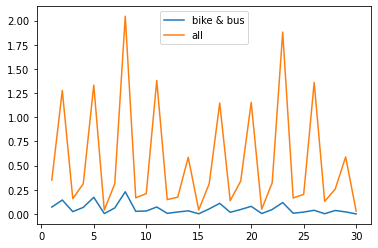

In [12]:
plt.plot(person[person['person_id'].isin(person_id_bike_bus)].groupby(by=['demo_num']).size()/2937, label='bike & bus')
plt.plot(person.groupby(by=['demo_num']).size()/56696, label='all')
plt.legend()

In [21]:
#delete school bus/bike only trips
print('previous trip shape', trip_revised.shape)
print('# of trips w.o bus/bike only', trip_revised[~trip_revised['person_id'].isin(person_id_bike_bus)].shape)

trip_revised = trip_revised[~trip_revised['person_id'].isin(person_id_bike_bus)]
person = person[~person['person_id'].isin(person_id_bike_bus)]
person = person[person['hhno'].isin(np.unique(trip_revised['hhno']))]

previous trip shape (1449958, 32)
# of trips w.o bus/bike only (1449958, 32)


In [22]:
#get person who lives in taz
person_id_home = np.unique(trip_revised['person_id'][(trip_revised['otaz'].isin(selected_taz)) & (trip_revised['opurp']==0)])

person_id_travel = np.unique(trip_revised['person_id'][~trip_revised['person_id'].isin(person_id_home)])

#we only keep the stay who lived in the selected test area
hhno_home = np.unique(trip_revised['hhno'][trip_revised['person_id'].isin(person_id_home)])
hhno_travel = np.unique(trip_revised['hhno'][trip_revised['person_id'].isin(person_id_travel)])


#only select stays who lives in the selected test area
del_person = person[person['hhno'].isin(hhno_travel)]
del_person = del_person['person_id'][~del_person['person_id'].isin(person_id_travel)]
person = person[~person['person_id'].isin(del_person.values)]

print('# person with home in the selected taz', len(person_id_home))
print('# person with Seattle in the selected taz', len(person_id_travel))

# person with home in the selected taz 82877
# person with Seattle in the selected taz 357389


In [23]:
#conduct stratified sampling based on the demo groups
num_home_ = len(person_id_home)
num_travel = len(person_id_travel)
num_stay = person[~person['person_id'].isin(np.unique(trip_revised['person_id']))].shape[0]
num_total = person.shape[0]

print(num_home_/num_total)
print(num_travel/num_total)
print(num_stay/num_total)

#get previous predicted data
param = pd.read_csv('G:/My Drive/2021/Bias/PSRC_od_simulation_2018/result_v1_all.csv', index_col = 0)
param = param['mean'][:31].values

sampling_per = param[:30]*param[-1]

print(person.shape)
print(person[person['person_id'].isin(person_id_home)].shape)
print(person[person['person_id'].isin(person_id_travel)].shape)
print(person[~((person['person_id'].isin(person_id_home))|(person['person_id'].isin(person_id_travel)))].shape)

0.18698671552082016
0.8063394581520856
0.007481544320704655
(443224, 52)
(82716, 52)
(357192, 52)
(3316, 52)


In [17]:
#delete person id without trips in travel pop
#check if we have person stay still
#person_travel_stay = person[person['hhno'].isin(hhno_travel)]
#person_travel_stay = person_travel_stay['person_id'][~person_travel_stay['person_id'].isin(person_id_travel)]

#person_travel_stay

In [24]:
#based on all the data
selected_personid_all = conduct_sampling(person, 'demo_num', sampling_per)

#based on stay, home and travel
selected_personid_home = conduct_sampling(person[person['person_id'].isin(person_id_home)],
                                         'demo_num',
                                         sampling_per)
selected_personid_travel = conduct_sampling(person[person['person_id'].isin(person_id_travel)],
                                         'demo_num',
                                         sampling_per)
selected_personid_stay = conduct_sampling(person[~((person['person_id'].isin(person_id_home))|(person['person_id'].isin(person_id_travel)))],
                                         'demo_num',
                                         sampling_per)

In [26]:
home_taz = {}
trip_home_taz = trip_revised[['opurp', 'otaz', 'hhno']][(trip_revised['hhno'].isin(hhno_home))&(trip_revised['opurp']==0)]                                      

index_ = 0
for i in trip_home_taz['hhno'].values:
    if i not in home_taz:
        home_taz[i] = trip_home_taz['otaz'].values[index_]
    index_ += 1
    
#del(trip_home_taz)

In [27]:
sample_trip_all, stays_id = get_sample_dttrips(selected_personid_all, trip_revised, True)
sample_trip_home =  get_sample_dttrips(selected_personid_home, trip_revised)
sample_trip_travel =  get_sample_dttrips(selected_personid_travel, trip_revised)

staystaz_all = get_stayed_taz(stays_id, home_taz)
staystaz_stay = get_stayed_taz(selected_personid_stay, home_taz)

In [ ]:
del(trip_revised)

In [37]:
print('# of sampled person all',len(selected_personid_all))
print('# of sampled residents' ,len(selected_personid_travel))
print('# of sampled travelers' ,len(selected_personid_home))
print('# of sampled residents+travelers', len(selected_personid_travel)+len(selected_personid_home)+len(selected_personid_stay))

# of sampled person all 11197
# of sampled residents 9044
# of sampled travelers 2073
# of sampled residents+travelers 11200


In [38]:
#get trip
sample_trip_home

,arrtm,dadtyp,day,deptm,dorp,dpcl,dpurp,dtaz,endacttm,half,...,travcost,travdist,travtime,trexpfac,tseg,tsvid,vot,person_id,de_hr,de_min
2214381,632,2,1,620,0,44306,1,493,1182,1,...,0,0,12,1,1,0,15,233984_1,10,20
2214382,1194,1,1,1182,0,159359,0,574,179,2,...,0,0,12,1,1,0,15,233984_1,19,42
2214662,365,2,1,357,1,159367,1,583,642,1,...,0,0,8,1,1,0,4,233515_2,5,57
2214663,1394,1,1,1387,0,159348,0,571,179,2,...,0,0,7,1,1,0,4,233515_2,23,7
2214664,661,4,1,642,0,608103,7,601,691,1,...,0,0,19,1,1,0,1,233515_2,10,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4034424,845,1,1,809,0,498623,0,653,179,2,...,0,1,36,1,2,0,3,427361_1,13,29
4037949,507,4,1,495,1,386566,5,631,524,1,...,0,0,12,1,1,0,13,427721_3,8,15
4037950,534,2,1,524,1,523924,1,600,1330,1,...,0,1,10,1,2,0,13,427721_3,8,44
4037951,1373,4,1,1330,0,498627,5,653,1402,2,...,0,2,43,1,1,0,13,427721_3,22,10


In [391]:
sample_trip_all.columns

Index(['index', 'arrtm', 'dadtyp', 'day', 'deptm', 'dorp', 'dpcl', 'dpurp',
       'dtaz', 'endacttm', 'half', 'hhno', 'id', 'mode', 'oadtyp', 'opcl',
       'opurp', 'otaz', 'pathtype', 'pno', 'sov_ff_time', 'tour', 'tour_id',
       'travcost', 'travdist', 'travtime', 'trexpfac', 'tseg', 'tsvid', 'vot',
       'person_id', 'de_hr', 'de_min'],
      dtype='object')

In [396]:
selected_col = ['otaz', 'dtaz', 'person_id', 'de_hr', 'de_min', 'mode', 'opurp', 'dpurp',
                'oadtyp','dadtyp','arrtm', 'deptm', 'dorp', 'opcl', 'dpcl', 'endacttm','hhno',     
                'pathtype', 'pno', 'tour', 'travcost', 'travdist', 'travtime', 'tseg', 'tsvid']

In [475]:
person.columns

Index(['index', 'hhno', 'id', 'pagey', 'pdiary', 'pgend', 'pno', 'ppaidprk',
       'pproxy', 'pptyp', 'psaudist', 'psautime', 'psexpfac', 'pspcl', 'pstaz',
       'pstyp', 'ptpass', 'puwarrp', 'puwdepp', 'puwmode', 'pwaudist',
       'pwautime', 'pwpcl', 'pwtaz', 'pwtyp', 'fraction_with_jobs_outside',
       'hh515', 'hhcu5', 'hhexpfac', 'hhftw', 'hhhsc', 'hhincome', 'hhoad',
       'hhparcel', 'hhptw', 'hhret', 'hhsize', 'hhtaz', 'hhuni', 'hhvehs',
       'hhwkrs', 'hownrent', 'hrestype', 'samptype', 'zone_id', 'person_id',
       'deage', 'deincome', 'deincome3', 'deincomepew', 'demo_num',
       'demo_noage'],
      dtype='object')

In [476]:
person[person['person_id'].isin(np.unique(sample_trip_all['person_id'][sample_trip_all['mode'].isin([2,8])]))].groupby(by=['demo_num']).size()

demo_num
1      6
2     44
3      1
4     29
5     64
6      1
7     11
8     54
9      3
10    13
11    29
12     1
13     4
14    15
16    13
17    31
18     1
19    15
20    41
21     1
22    10
23    20
24     4
25     6
26     9
27     1
28    10
29     7
30     1
dtype: int64

In [467]:
len(np.unique(sample_trip_all['person_id']))

11226

0.03964012114733654

In [444]:
#Trip mode (1=walk, 2=bike, 3=sov, 4=hov 2, 5=hov 3+, 6=walk to transit,
#7=park and ride, 8=school bus, 9=TNC, 10=other – survey only) 
#since sumo doesn't include bike mode, thus we delete bike mode

sample_trip_all.groupby('mode').size()
#delete person whose mode is bike, or school bus
print('# of persons', len(np.unique(sample_trip_all['person_id'])))
print('# of person without bike mode',
      len(np.unique(sample_trip_all['person_id'][~(sample_trip_all['mode']==2)])))

print('# of person withour bike and school bus mode',
      len(np.unique(sample_trip_all['person_id'][~(sample_trip_all['mode'].isin([2, 8]))])))

# of persons 11226
# of person without bike mode 11154
# of person withour bike and school bus mode 11130


In [449]:
sample_trip_all = sample_trip_all[selected_col][~(sample_trip_all['mode'].isin([2, 8]))]

In [458]:
print(sample_trip_all.groupby(by=['mode']).size())
print(sample_trip_home.groupby(by=['mode']).size())
print(sample_trip_travel.groupby(by=['mode']).size())

mode
1    10175
3    10844
4     5482
5     3034
6     5168
9     1191
dtype: int64
mode
1    6073
2     274
3    1586
4     917
5     396
6     815
8      40
9     255
dtype: int64
mode
1    3963
2     377
3    9078
4    4477
5    2777
6    4241
8      93
9     949
dtype: int64


In [40]:
#mode
#1=walk, 2=bike, 3=sov, 4=hov 2, 5=hov 3+, 6=walk to transit, 
#7=park and ride, 8=school bus, 9=TNC, 10=other – survey only
#decode mode
#walk 1, 6
#veh 3, 4, 5, 9
#other 2, 8 

decode_mode = lambda x: 1 if x in [1, 6] else (2 if x in [3, 4, 5, 9] else 3)



C:\Users\29700\AppData\Local\Temp\ipykernel_16760\138560002.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_trip_all['mode_d'] = sample_trip_all['mode'].apply(decode_mode)


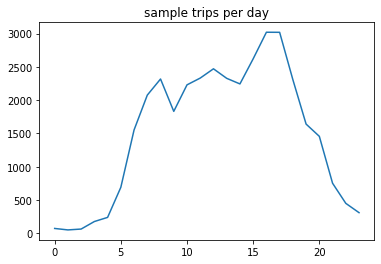

In [55]:
sample_dt = sample_trip_all
plt.plot(sample_dt.groupby(by=['de_hr']).size())
plt.title('sample trips per day')

del(sample_dt)

In [59]:
def write_dt(sample_):
    sample_dt = sample_.copy()
    sample_dt['mode_d'] = sample_dt['mode'].apply(decode_mode)
    sample_dt = sample_dt[['person_id', 'de_hr', 'de_min', 'mode_d', 'otaz', 'dtaz']].sort_values(by=['person_id', 'de_hr', 'de_min'])
    return(sample_dt)

In [65]:
#save 2 csv
sample_trip_all.to_csv('../SUMO_simulation/appsim/sample_trip_all_10per.csv')
sample_trip_travel.to_csv('../SUMO_simulation/appsim/sample_trip_home_10per.csv')
sample_trip_home.to_csv('../SUMO_simulation/appsim/sample_trip_travel_10per.csv')

In [69]:
#combine index 
sample_trip_travel['p_ht'] = 0
sample_trip_home['p_ht'] = 1

sample_trip_ht = pd.concat([sample_trip_home, sample_trip_travel], axis=0, ignore_index=True)
sample_trip_ht['mode_d'] = sample_trip_ht['mode'].apply(decode_mode)

sample_trip_ht.to_csv('../SUMO_simulation/appsim/sample_trip_ht_10per.csv')
del(sample_trip_home, sample_trip_travel)

C:\Users\29700\AppData\Local\Temp\ipykernel_16760\528876012.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_trip_travel['p_ht'] = 0
C:\Users\29700\AppData\Local\Temp\ipykernel_16760\528876012.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_trip_home['p_ht'] = 1


In [ ]:
#check the sample data

# trip summary count    11113.000000
mean         3.261226
std          1.926163
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         16.000000
dtype: float64


(array([7.413e+03, 1.585e+03, 1.283e+03, 3.230e+02, 2.190e+02, 2.080e+02,
        4.700e+01, 2.800e+01, 2.000e+00, 5.000e+00]),
 array([ 2. ,  3.4,  4.8,  6.2,  7.6,  9. , 10.4, 11.8, 13.2, 14.6, 16. ]),
 <BarContainer object of 10 artists>)

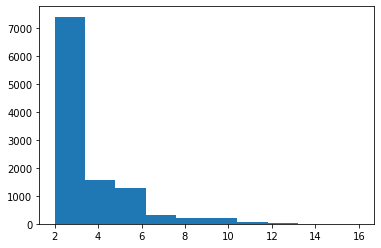

In [74]:
print('# trip summary', sample_trip_all.groupby(by='person_id').size().describe())
plt.hist(sample_trip_all.groupby(by='person_id').size())

# trip summary count    11117.000000
mean         3.285059
std          1.947855
min          2.000000
25%          2.000000
50%          2.000000
75%          4.000000
max         18.000000
dtype: float64


(array([7.316e+03, 2.322e+03, 6.320e+02, 5.420e+02, 1.180e+02, 1.480e+02,
        2.900e+01, 6.000e+00, 2.000e+00, 2.000e+00]),
 array([ 2. ,  3.6,  5.2,  6.8,  8.4, 10. , 11.6, 13.2, 14.8, 16.4, 18. ]),
 <BarContainer object of 10 artists>)

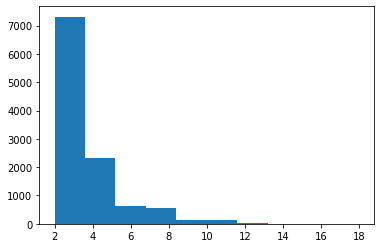

In [75]:
print('# trip summary', sample_trip_ht.groupby(by='person_id').size().describe())
plt.hist(sample_trip_ht.groupby(by='person_id').size())

In [ ]:
#revise the taz 
#assign the od


In [78]:
sample_trip_all.columns

Index(['arrtm', 'dadtyp', 'day', 'deptm', 'dorp', 'dpcl', 'dpurp', 'dtaz',
       'endacttm', 'half', 'hhno', 'id', 'mode', 'oadtyp', 'opcl', 'opurp',
       'otaz', 'pathtype', 'pno', 'sov_ff_time', 'tour', 'tour_id', 'travcost',
       'travdist', 'travtime', 'trexpfac', 'tseg', 'tsvid', 'vot', 'person_id',
       'de_hr', 'de_min', 'mode_d'],
      dtype='object')

In [83]:
sample_trip_all.shape

(36242, 33)

In [89]:
#sample_trip_all[sample_trip_all['mode_d']==1]
def get_walk_pop(sample_trip_all):
    sample_walk = (sample_trip_all[sample_trip_all['mode_d']==1]).groupby(by=['otaz','dtaz']).size().to_frame()
    sample_walk.reset_index(inplace=True)
    sample_walk.columns = ['otaz', 'dtaz', 'num_od']
    print('walk pop shape', sample_walk.shape)
    print('walk pop od summary', sample_walk['num_od'].describe())
    return(sample_walk_pop)


<function __main__.get_walk_pop(sample_trip_all)>

## Explore the demographic factors
### demographic factors
(pptyp, pagey, pgend, hhincome, hhownrent, hhrestype)\
pptyp: person type\
1= full time worker, 2 =part time worker, 3=non-worker age 65+, 4 = other non-working adult, 5 = university student, 6 = grade school student/child age 16+, 7 = child age 5-15, 8 = child age 0-4. 

pagey: age in years\
age group: 
<18, 18-29, 30-49, 50-64, >65 (need to be decoded)

pgend: Gender (1=male, 2=female, 9=missing data for estimation)

hhincome: household income (The household annual income, in integer dollars. (A negative value is interpreted as missing data in DaySim estimation mode.)
[Source](https://money.usnews.com/money/personal-finance/family-finance/articles/where-do-i-fall-in-the-american-economic-class-system#:~:text=A%20family%20earning%20between%20%2432%2C048,more%20than%20%24373%2C894%20are%20rich).

| INCOME GROUP       | INCOME (2019, $) | 
| :---               | :---             |
| Poor or near-poor  | 32,048 or less   |
| Lower-middle class | 32,048 - 53,413  |
| Middle class       | 53,413 - 106,827 |
| Upper-middle class | 106,827 - 373,894|
| Rich               | 373,894 and up   |

hhownrent: Household own versus rent status. (This could be optional as input, as it is not currently used in the DaySim model code.) 

hhrestype: Household residence building type. (This could be optional as input, as it is not currently used in the DaySim model code.)  


### detailed work/study type
(pwtyp, pstyp, hhwkrs, hhvehs, hhftw, hhptw, hhret, hhoad, hhuni, hhhsc)\
pwtyp: Worker type (0=non-worker, 1=full time worker, 2=part time worker)\
pstyp: student type (0=non-student, 1=full time student, 2=part time student if known – part-time distinction not used in DaySim code)\
Hhwkrs: the number of workers in the household*\
Hhvehs: the number of auto in the household*\
Hhftw:The number of HH members with person type=full-time worker.   (This could be optional as input, as it is computed by DaySim.)\
Hhptw: The number of HH members with person type=part-time worker.   (This could be optional as input, as it is computed by DaySim.)\
Hhret: The number of HH members with person type=retired adult.   (This could be optional as input, as it is computed by DaySim.)\
hhoad: The number of HH members with person type=other non-working adult.   (This could be optional as input, as it is computed by DaySim.)\
hhuni:The number of HH members with person type=university student.   (This could be optional as input, as it is computed by DaySim.)\
hhhsc:The number of HH members with person type=grade school student age 16+.   (This could be optional as input, as it is computed by DaySim.)

### travel based factors
(pwautime, pwaudist, psautime, psaudist, puwmode, puwarrp, puwdepp, ptpass, ppaidprk)
#### work
pwautime: The 1-way peak auto travel time between the residence and usual work parcels (a real number of minutes, -1 if no usual work location. Could be optional as input, used as output for calibration.)\
pwaudist: The 1-way peak auto distance between the ...\
psautime: The 1-way peak auto travel time between the residence and usual school parcels (a real number of minutes, -1 if no usual school location. Could be optional as input, used as output for calibration.)\
psaudist: The 1-way peak auto travel distance between the residence and usual school parcels (a real number of miles, -1 if no usual school location. Could be optional as input, used as output for calibration.)

#### mode
puwmode: The usual mode used to work

#### time
puwarrp: The usual arrival period at work\
puwdepp: The usual departure period from work\
ptpass: Transit pass ownership (0=no, 1=yes. This is predicted by DaySim, so could be an optional input in application mode.)\
ppaidprk: Worker has to pay to park at work (0=no, 1=yes.   This is predicted by DaySim, so could be an optional input in application mode.)



## Add land use info
* [data source](https://github.com/psrc/soundcast/releases/tag/v3.0.1_RTP)
* [data info](https://github.com/psrc/soundcast/wiki/lutype_lookup)
* [land use info](https://github.com/psrc/soundcast/wiki/Inputs#land-use)